TAHAP LOAD DATA DARI FILE CSV

In [616]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, butter, firwin, lfilter, filtfilt, freqz
from scipy.fft import fft
from scipy import pi, signal
from sklearn.decomposition import FastICA
from scipy.signal import welch

data_path = './s1_s1_ec.csv'

df = pd.read_csv(data_path)

display(df.head())
print(f'Dimensi Data: {df.shape}')

,F3,FC5,AF3,F7,T7,P7,O1,O2,P8,T8,F8,AF4,FC6,F4,Timestamp,Date,Time
0,4197.948718,4173.974359,4187.564102,4187.051282,4196.153846,4199.230769,4185.000000,4203.589744,4204.871795,4195.512820,4156.666666,4199.487179,4187.564102,4199.102564,14-04-2018 12:01:43.828,14-04-2018,12:01:43.828
1,4199.102564,4172.564102,4190.128205,4176.282051,4188.461538,4202.820513,4186.282051,4202.692308,4203.974359,4198.333333,4185.769231,4192.820513,4185.000000,4198.461538,14-04-2018 12:01:43.828,14-04-2018,12:01:43.828
2,4190.512820,4171.666667,4184.615384,4185.769231,4186.538461,4202.692308,4186.923077,4198.846154,4199.871795,4187.051282,4200.897436,4180.000000,4185.641026,4189.871795,14-04-2018 12:01:43.831,14-04-2018,12:01:43.831
3,4189.615384,4168.717949,4186.666667,4182.820513,4187.692308,4195.769231,4185.897436,4198.589743,4201.410256,4183.846154,4166.923077,4198.333333,4191.025641,4198.846154,14-04-2018 12:01:43.832,14-04-2018,12:01:43.832
4,4198.846154,4176.666667,4193.205128,4184.230769,4184.743590,4202.051282,4189.743590,4203.846154,4203.461538,4198.846154,4196.666667,4194.743590,4193.846154,4196.923077,14-04-2018 12:01:43.832,14-04-2018,12:01:43.832


Dimensi Data: (30720, 17)


TAHAP PENGAMBILAN DAN CUT-OFF DATA AF3, AF4, O1, DAN O2

In [617]:
datasetSpec = ["AF3", "AF4", "O1", "O2"]

def cutoff(data, baseline = 5119, duration = 120, sampling = 256):
    dur = (duration * sampling)
    cut = data[baseline:baseline+dur]
    res = []

    for i in datasetSpec :
        res.append(cut[i].values)

    eeg = np.array(res)

    return eeg

In [618]:
dataRAW = cutoff(df)
print(dataRAW)
print(dataRAW.shape)
print(type(dataRAW))

[[4202.43589737 4202.05128199 4202.5641025  ... 4125.64102537
  4123.46153819 4120.51282024]
 [4210.38461532 4207.43589737 4204.23076917 ... 4160.25641005
  4154.87179467 4149.48717928]
 [4185.89743576 4187.69230756 4188.58974345 ... 4172.30769217
  4171.41025628 4170.76923063]
 [4201.15384609 4201.53846147 4200.76923063 ... 4148.71794851
  4150.38461518 4148.97435877]]
(4, 25601)
<class 'numpy.ndarray'>


TAHAP NORMALISASI AMPLITUDO AGAR SESUAI DENGAN STANDAR

In [619]:
def normalize(x):
    xmin = min(x)
    xmax = max(x)
    maxamp = 0
    xnorm = 0

    if (abs(xmax) >= abs(xmin)):
        maxamp = abs(xmax)
    else:
        maxamp = abs(xmin)

    if (xmin == xmax):
        return 'Cannot normalize the signal.'
    else:
        xnorm = x / maxamp
        return xnorm

def normalize_eeg(data, channel_num = 4):

    eeg_norm = []
    for i in range(channel_num):
        s = normalize(data[i])
        s.transpose()
        s = list(s)
        eeg_norm.append(s)

    return np.asarray(eeg_norm)

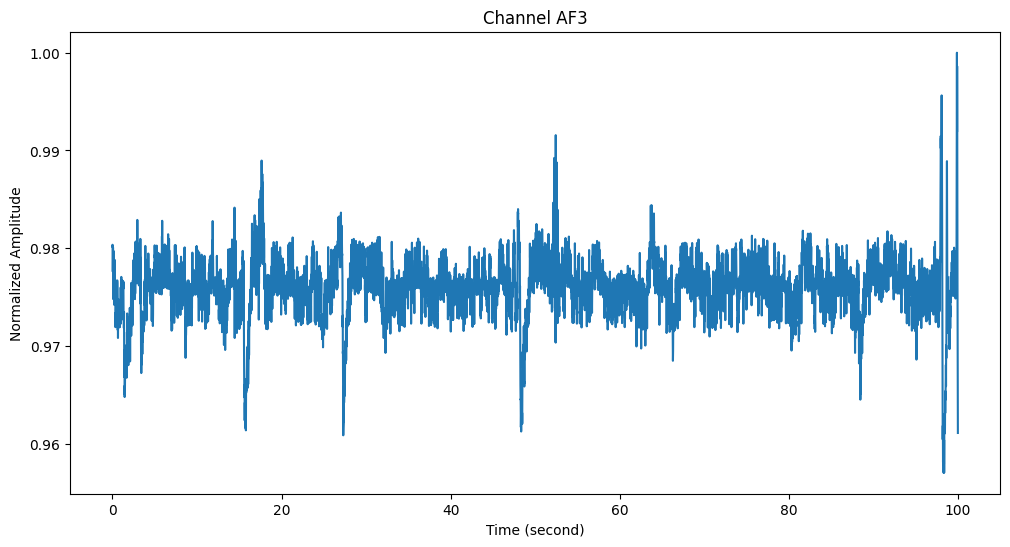

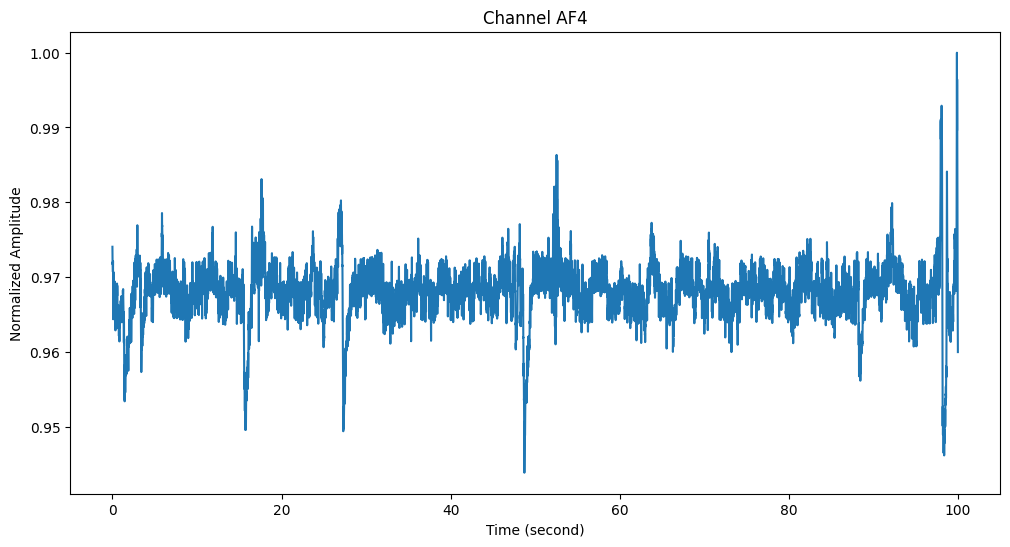

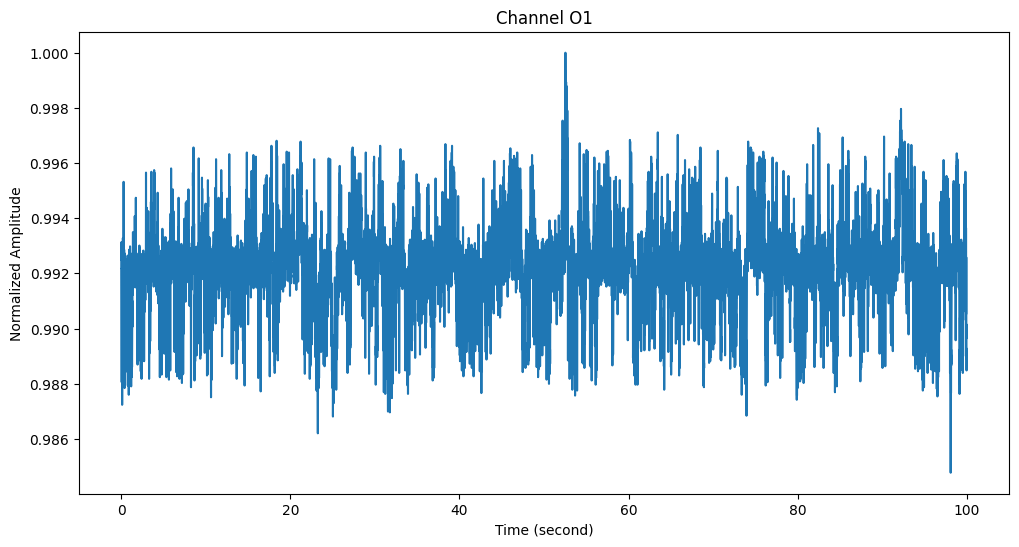

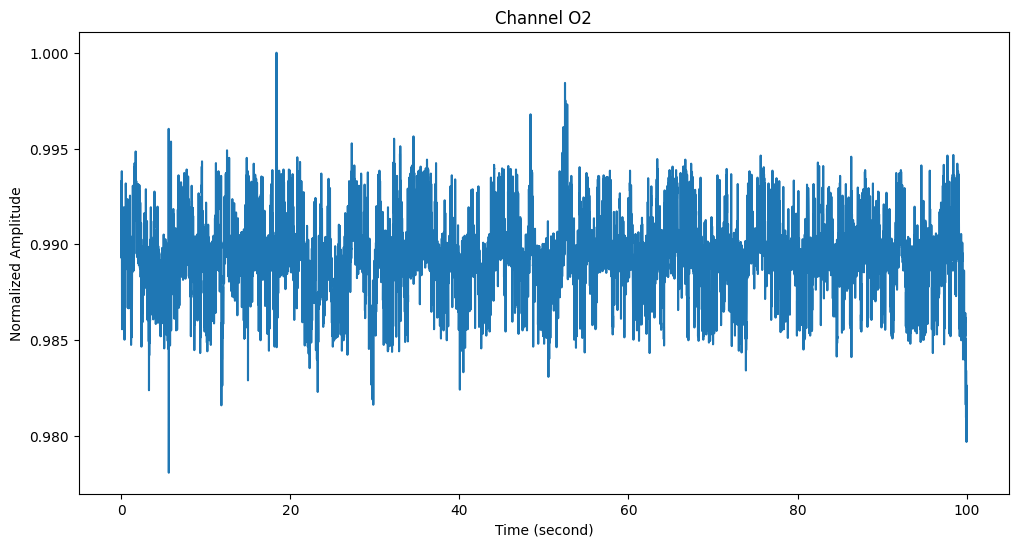

In [620]:
dataPROCESS = normalize_eeg(dataRAW)
times = np.arange(len(dataPROCESS[0]))/256

for i, channelName in enumerate(datasetSpec) :
    plt.figure(figsize=(12, 6))
    plt.plot(times, dataPROCESS[i])
    plt.title(f'Channel {channelName}')
    plt.xlabel('Time (second)')
    plt.ylabel('Normalized Amplitude')
    plt.show()

TAHAP DEKOMPOSISI UNTUK MEMISAHKAN SINYAL EEG DENGAN EOG

In [621]:
def get_ica_comps(data, comp = 4, max_iter = 200, random_state = 0, tol = 0.05):

    data = data.transpose()
    ica = FastICA(n_components=5, random_state= random_state, tol = tol)
    comps = ica.fit_transform(data)

    return comps, ica

/home/ghost/Documents/tubes_PSB/venv/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:582: UserWarning: n_components is too large: it will be set to 4
  warnings.warn(


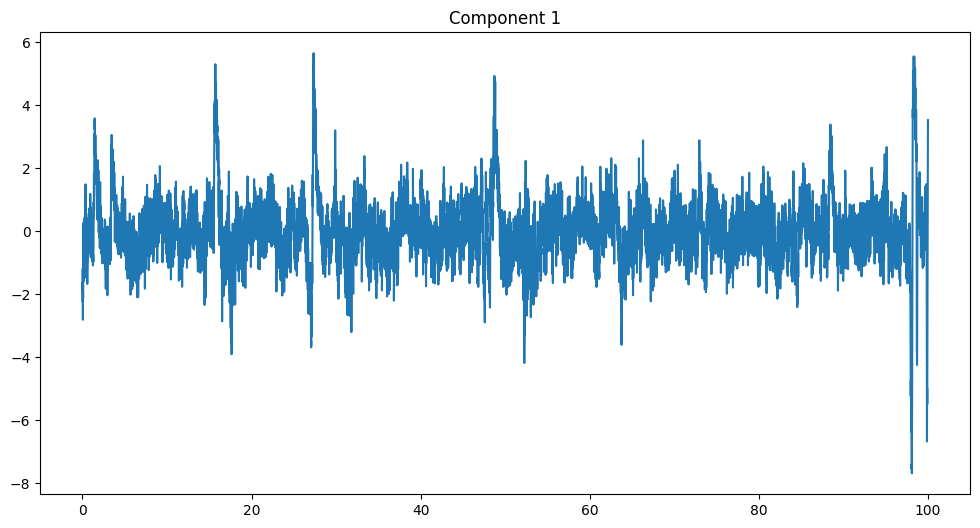

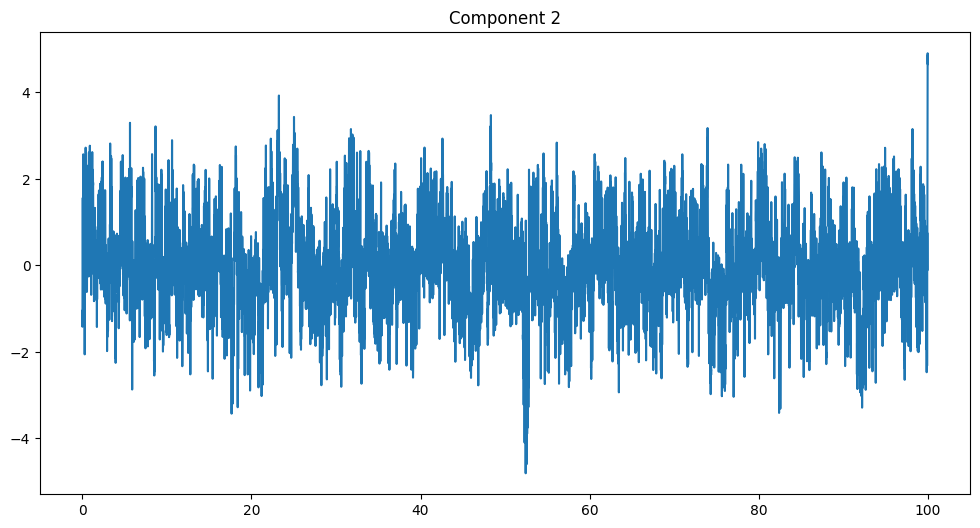

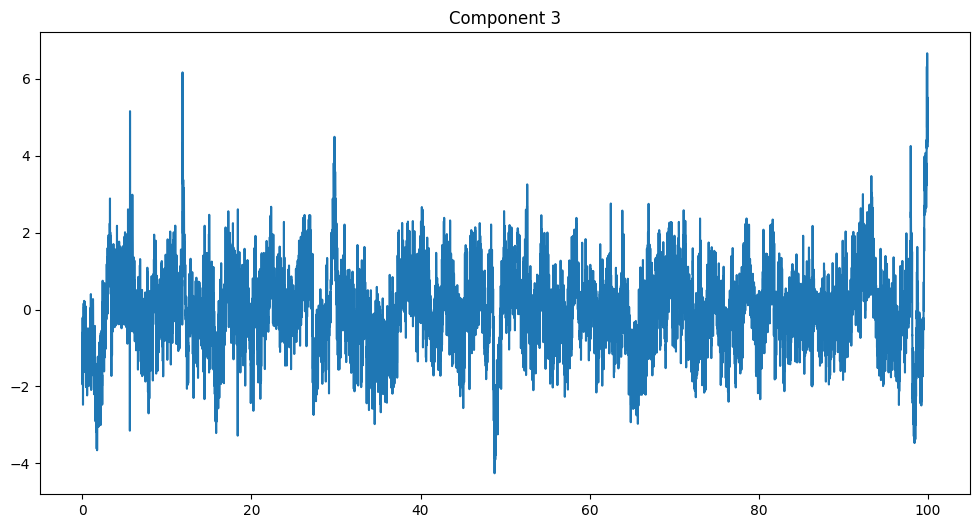

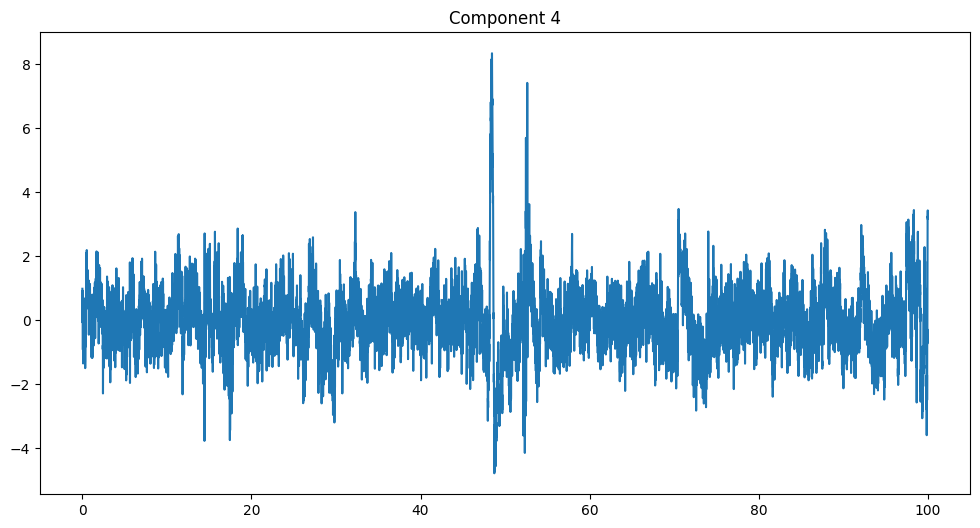

In [622]:
dataICA, ica = get_ica_comps(dataPROCESS)

for i in range(len(datasetSpec)) :
    plt.figure(figsize=(12, 6))
    plt.plot(times, dataICA.transpose()[i])
    plt.title(f'Component {i+1}')

In [623]:

def comps_restored(ica_comps, comps, init_ica):
    reconstruct = ica_comps.copy()
    reconstruct[:, comps] = 0
    restored = init_ica.inverse_transform(reconstruct)

    return restored

HASIL DARI DEKOMPOSISI SINYAL

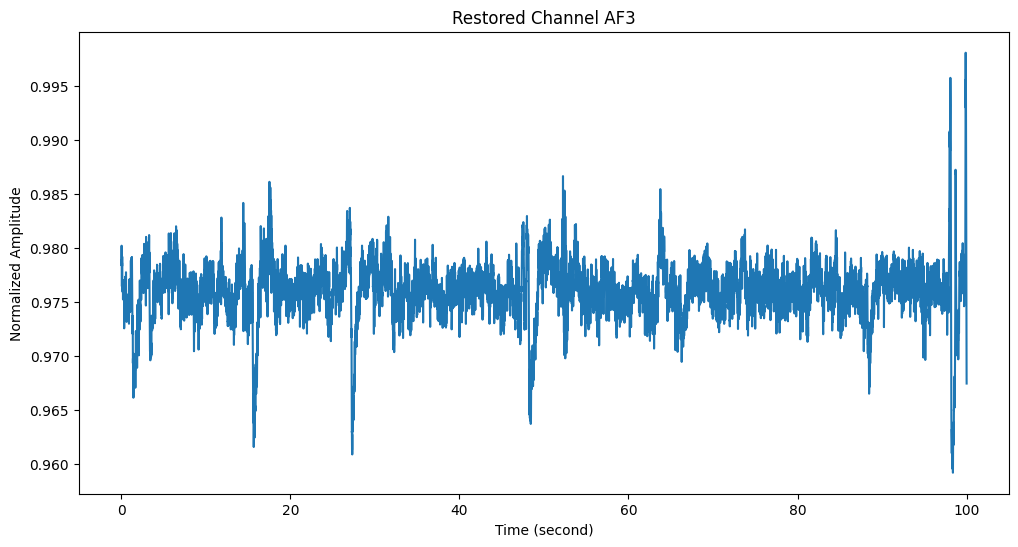

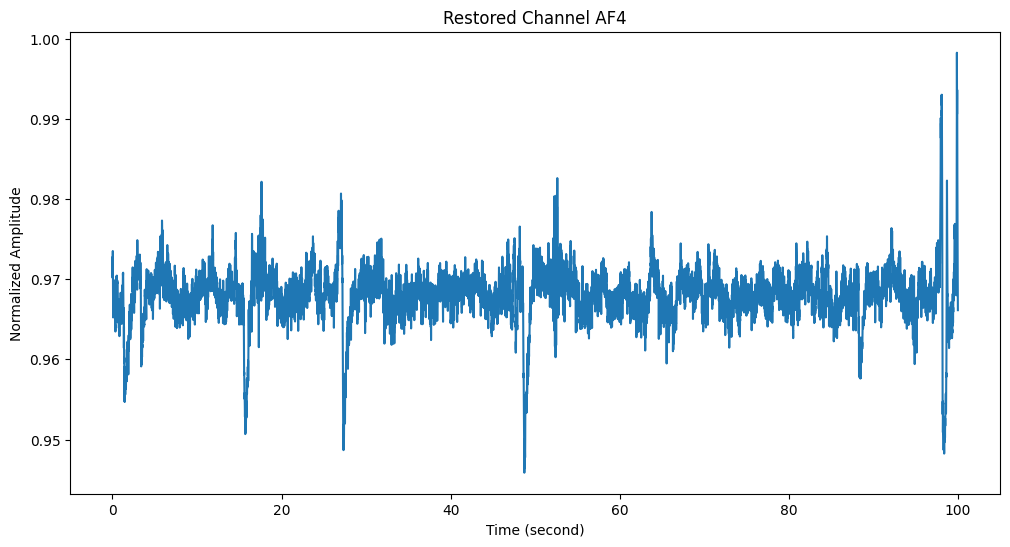

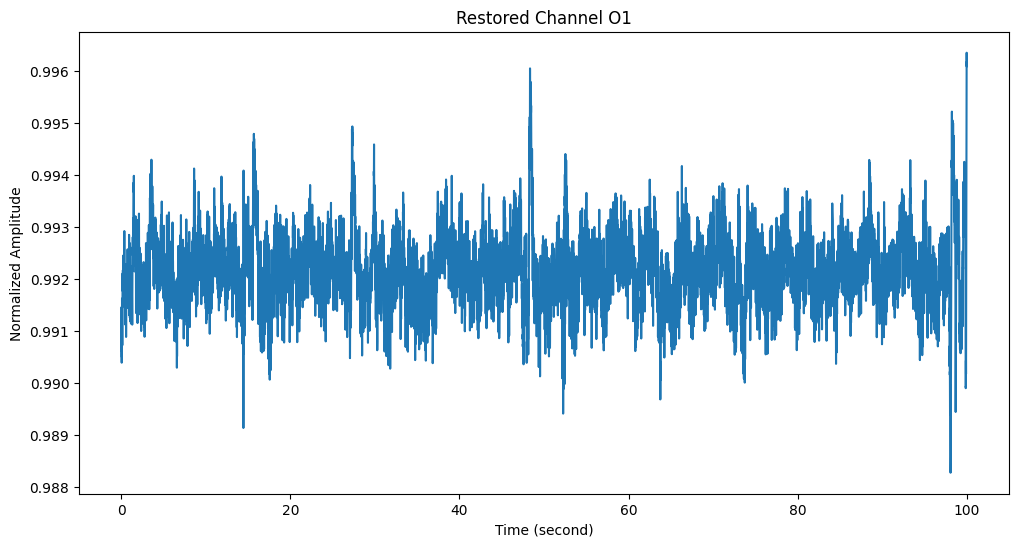

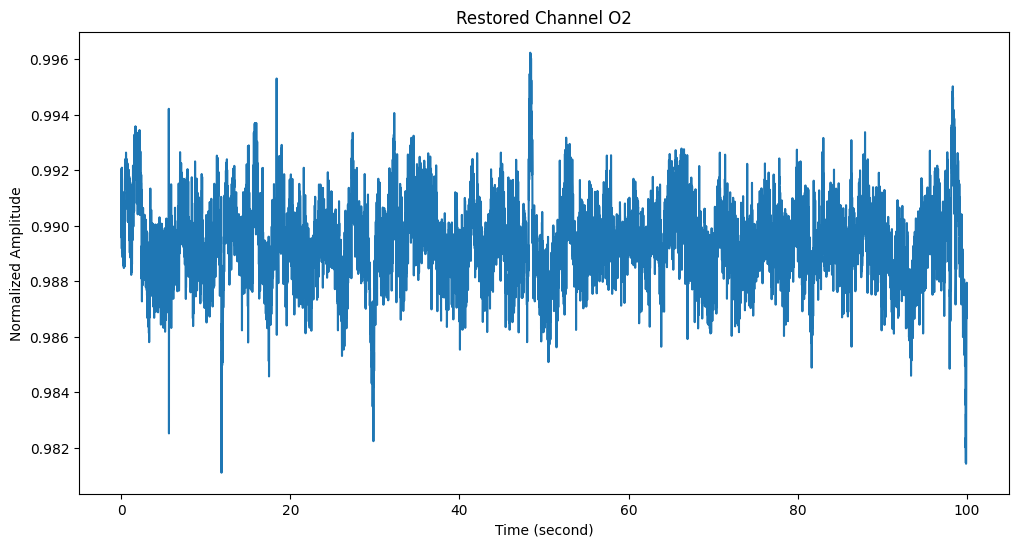

In [624]:
dataHASIL = comps_restored(dataICA, [1], ica)
dataHASIL = np.transpose(dataHASIL)

for i, channelName in enumerate(datasetSpec) :
    plt.figure(figsize=(12, 6))
    plt.plot(times, dataHASIL[i])
    plt.title(f'Restored Channel {channelName}')
    plt.xlabel('Time (second)')
    plt.ylabel('Normalized Amplitude')
    plt.show()

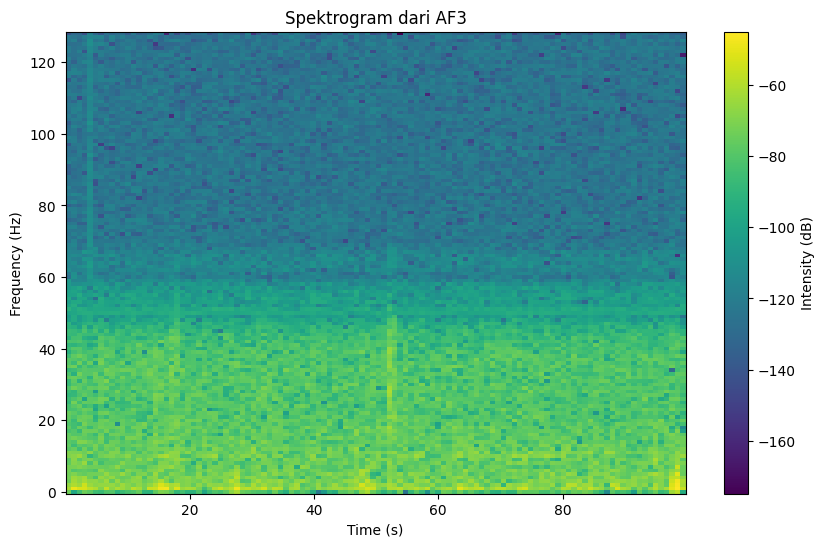

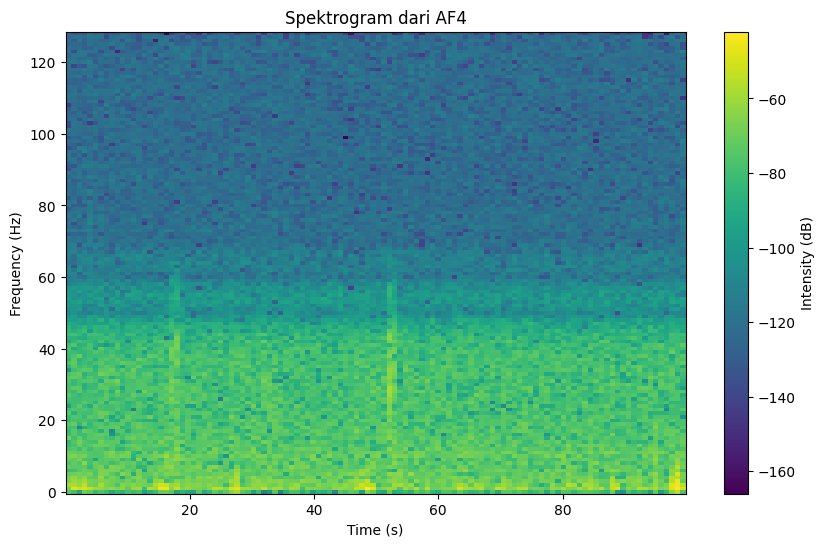

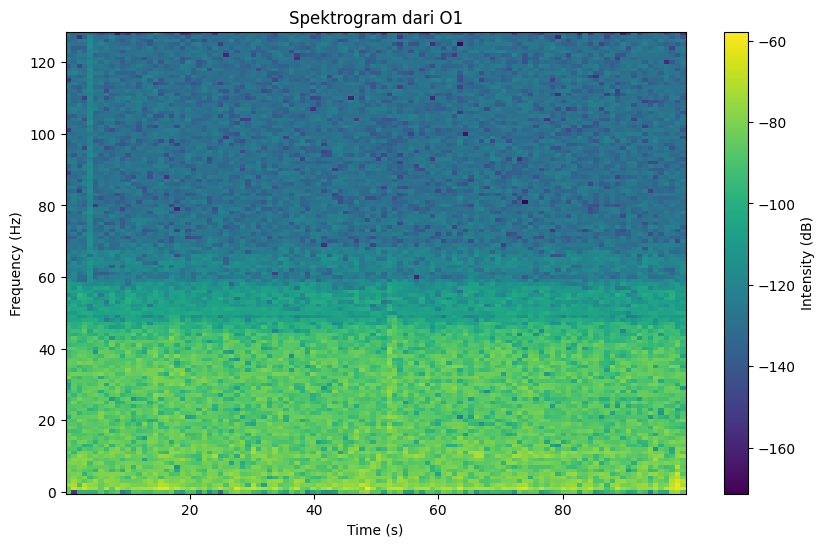

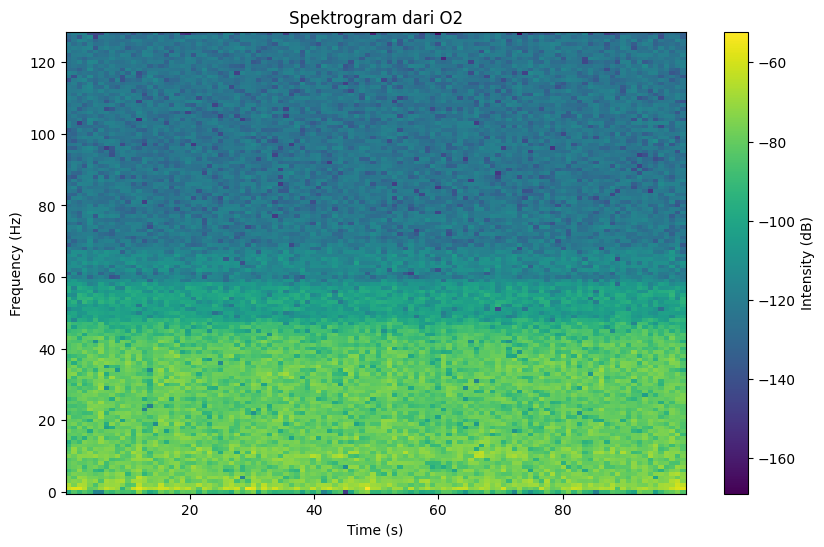

In [625]:
for i, channelName in enumerate(datasetSpec) :
    freqs, T, Sxx = spectrogram(dataHASIL[i], fs=256)

    plt.figure(figsize=(10, 6))
    plt.pcolormesh(T, freqs, 10 * np.log10(Sxx), shading='auto')
    plt.colorbar(label='Intensity (dB)')
    plt.title(f'Spektrogram dari {channelName}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

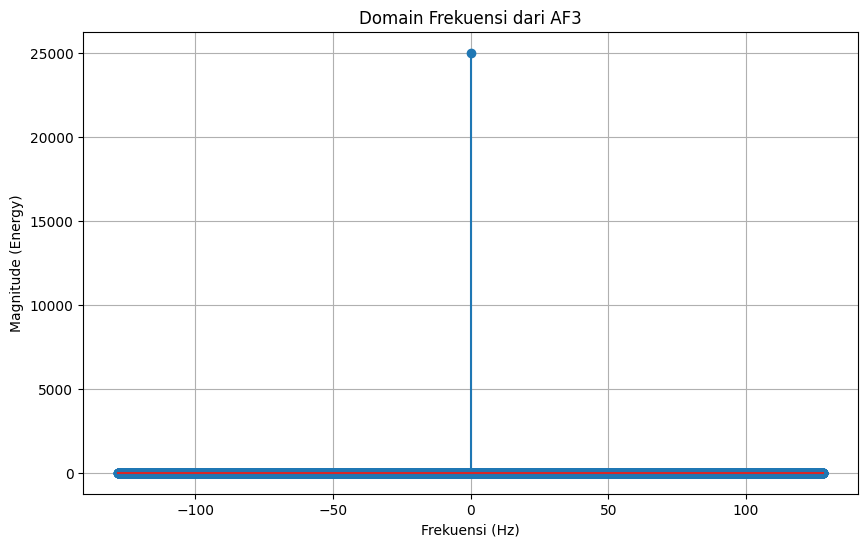

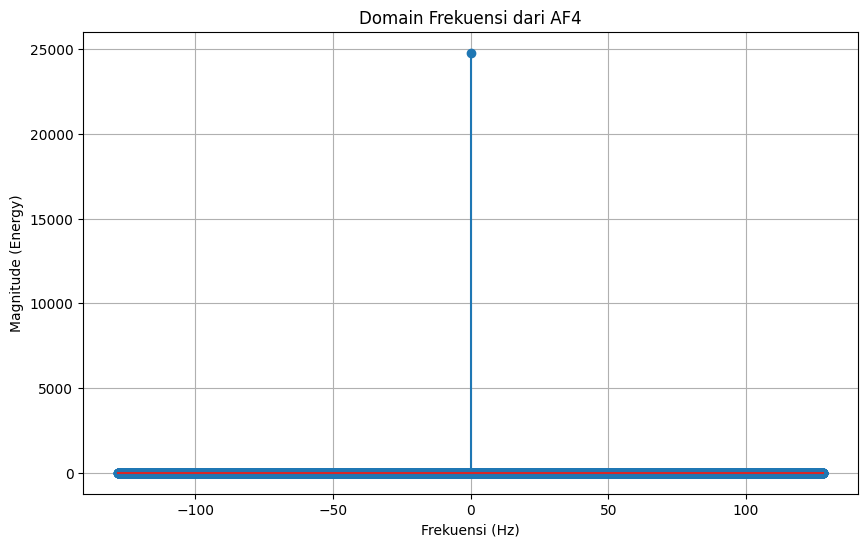

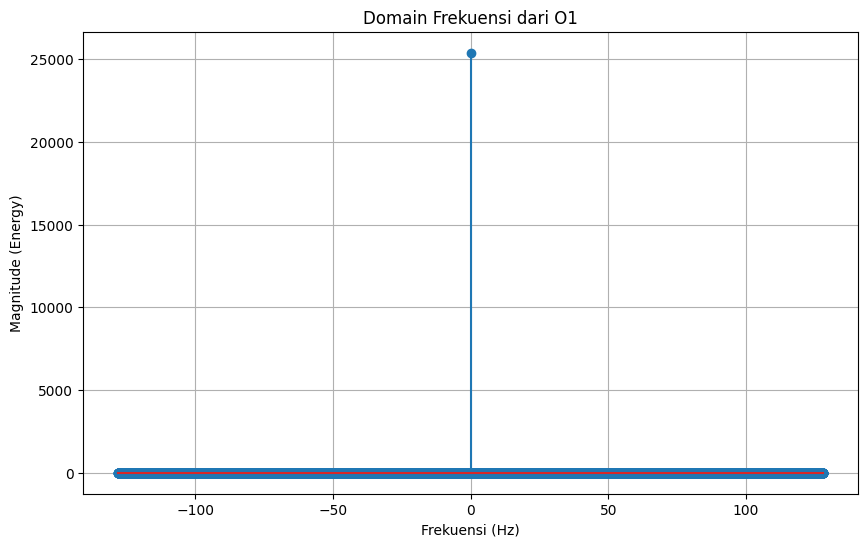

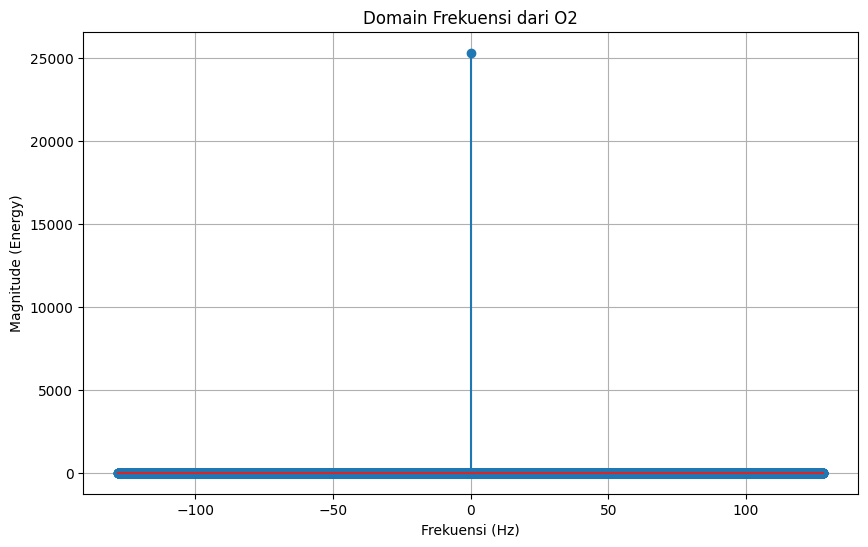

In [626]:
for i, channelName in enumerate(datasetSpec) :
    frequencies = np.fft.fftfreq(len(times), times[-1]/len(times))
    fft_values = np.fft.fft(dataHASIL[i])

    plt.figure(figsize=(10, 6))
    plt.stem(frequencies, np.abs(fft_values))
    plt.title(f'Domain Frekuensi dari {channelName}')
    plt.xlabel('Frekuensi (Hz)')
    plt.ylabel('Magnitude (Energy)')
    plt.grid(True)
    plt.show()

In [627]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

In [628]:
for i, channelName in enumerate(datasetSpec) :
    snr = signaltonoise(dataHASIL[i])
    print(channelName, " => ", snr)

AF3  =>  367.31844253961384
AF4  =>  277.91792385580686
O1  =>  1492.7460783278855
O2  =>  732.5478142889903


TAHAP FILTERISASI CHANNEL UNTUK MEMBUANG LINE NOISE ( 60HZ )

In [629]:
def filterDesign(n = 205, fc = 60, hfs = 128) :
    return firwin(n, fc/hfs, window="hamming", pass_zero="highpass")

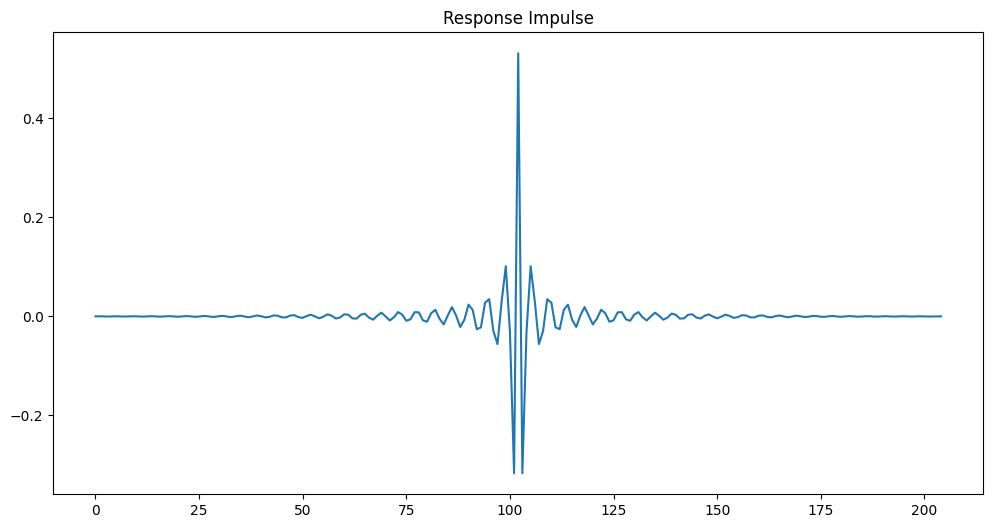

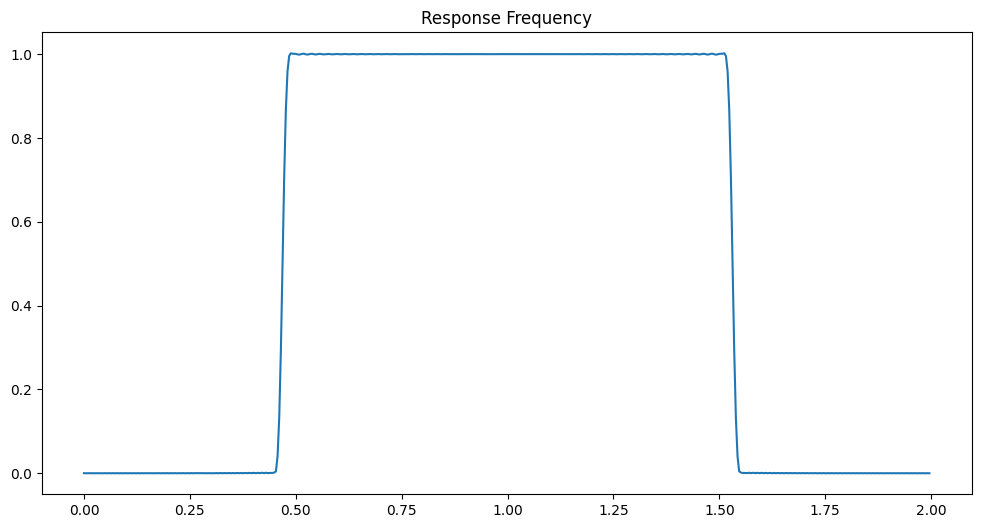

In [630]:
bahanFILTER = filterDesign()

plt.figure(figsize=(12, 6))
plt.plot(bahanFILTER)
plt.title("Response Impulse")
plt.show()

w, h = freqz(bahanFILTER, 1, whole=True)

plt.figure(figsize=(12, 6))
plt.plot(w/pi, abs(h))
plt.title("Response Frequency")
plt.show()

HASIL FILTERISASI SINYAL

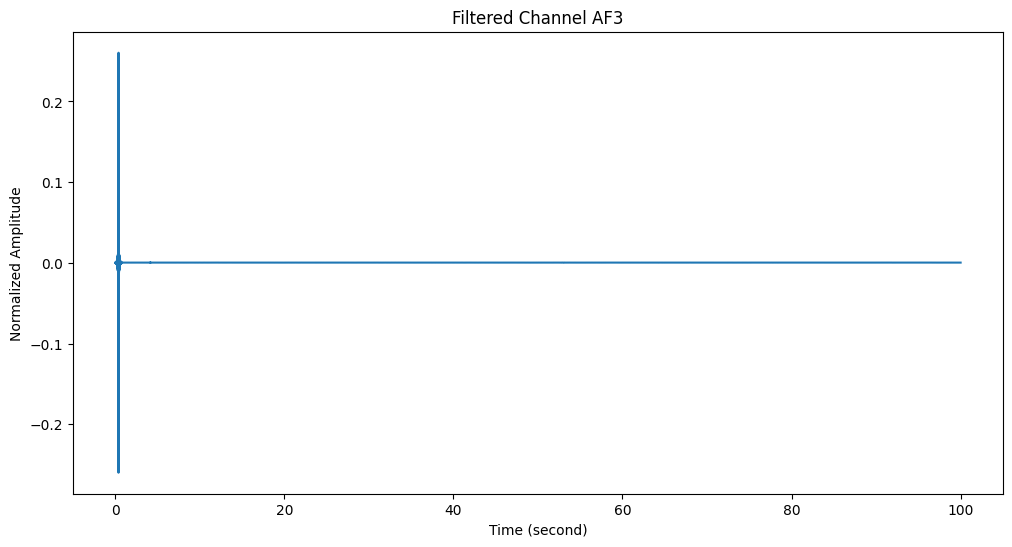

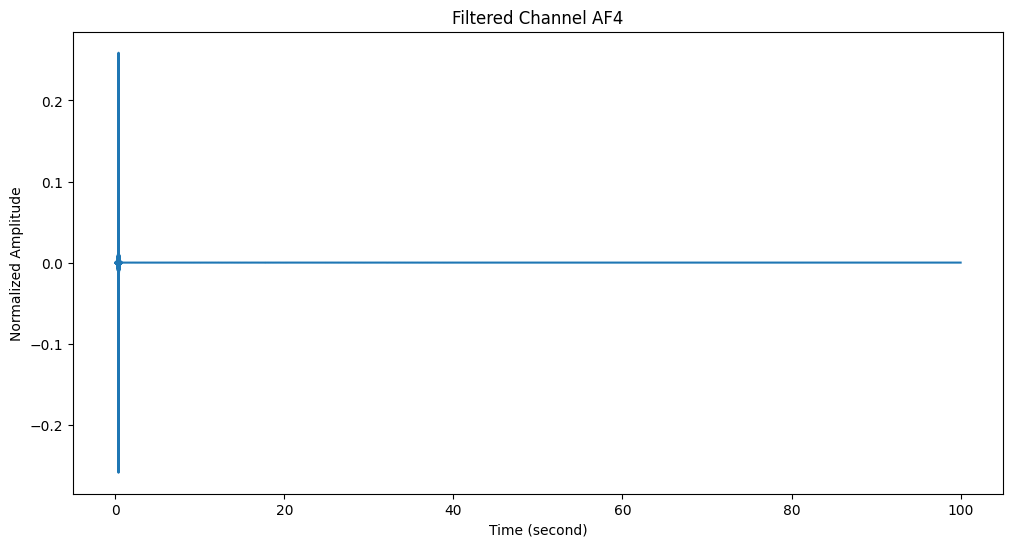

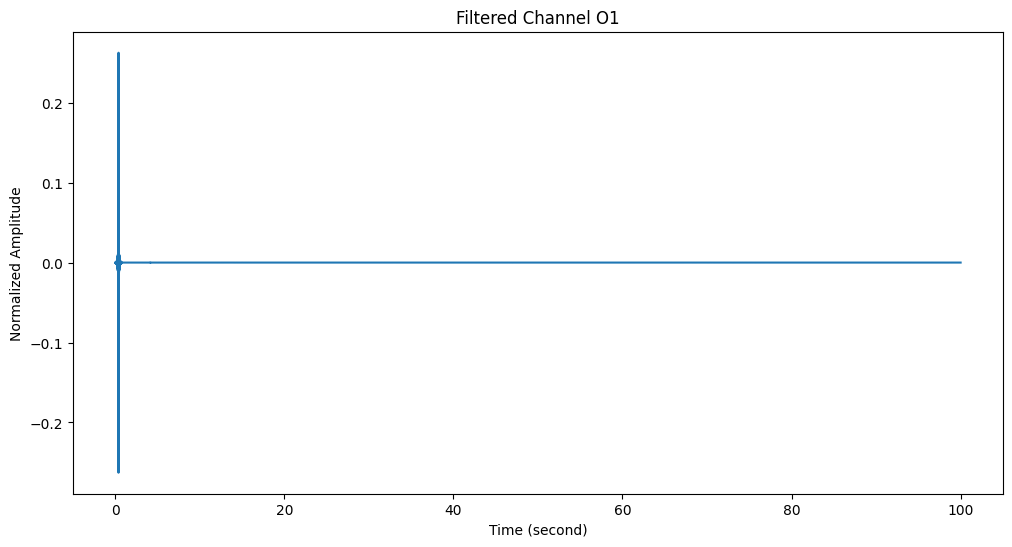

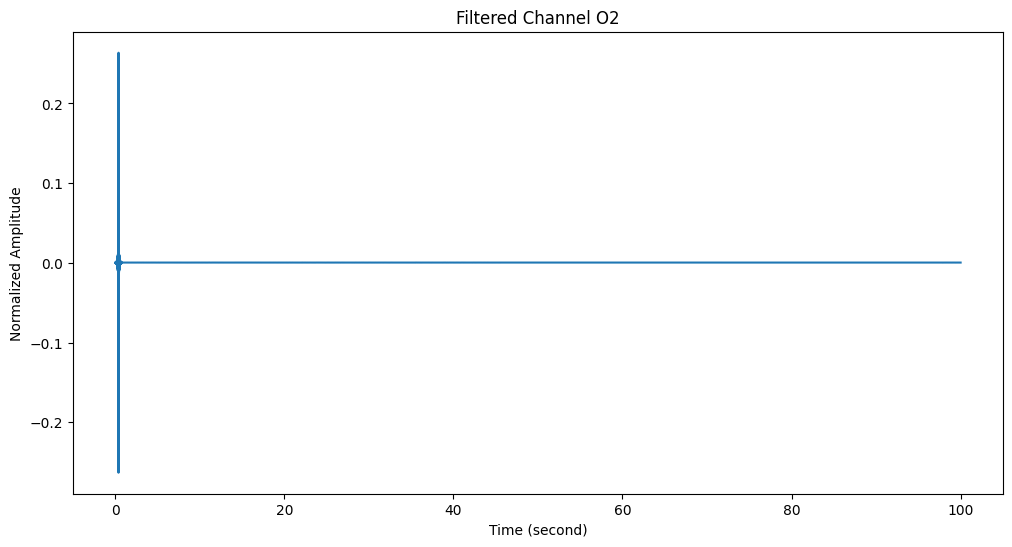

In [631]:
dataHASILFILTER = lfilter(bahanFILTER, [1], dataHASIL)

for i, channelName in enumerate(datasetSpec) :
    plt.figure(figsize=(12, 6))
    plt.plot(times,dataHASILFILTER[i])
    plt.title(f'Filtered Channel {channelName}')
    plt.xlabel('Time (second)')
    plt.ylabel('Normalized Amplitude')

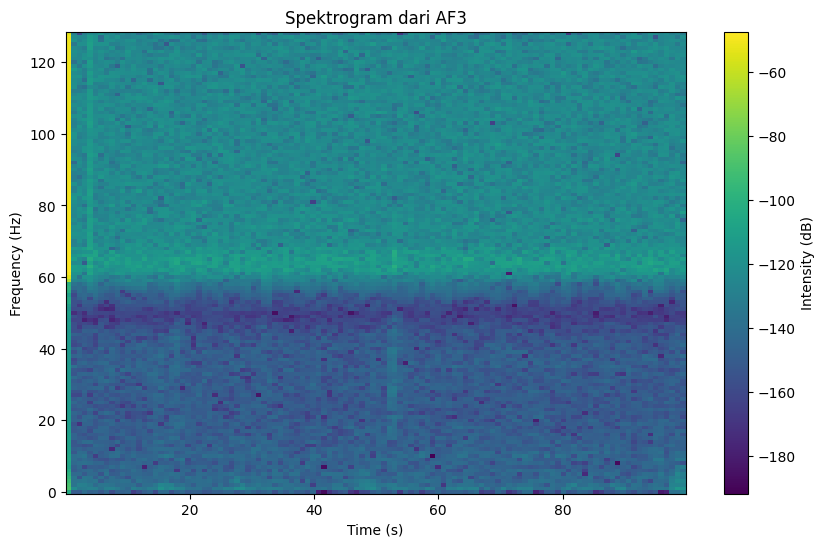

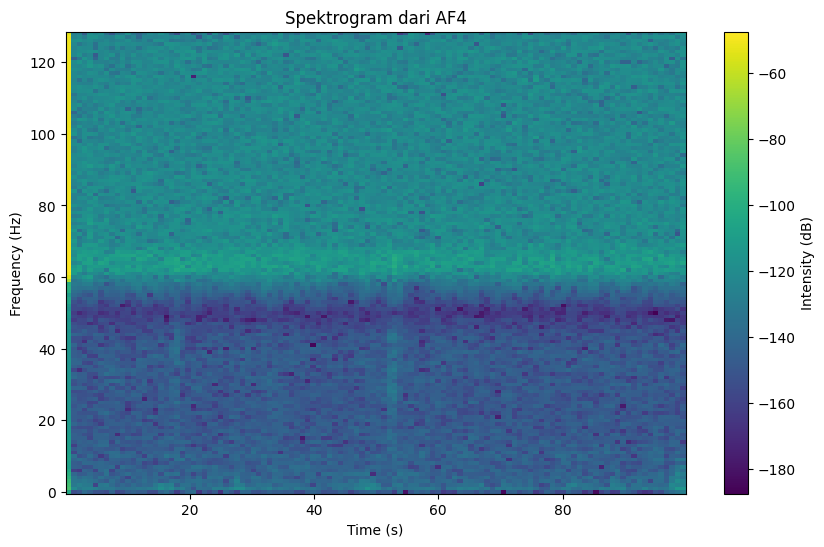

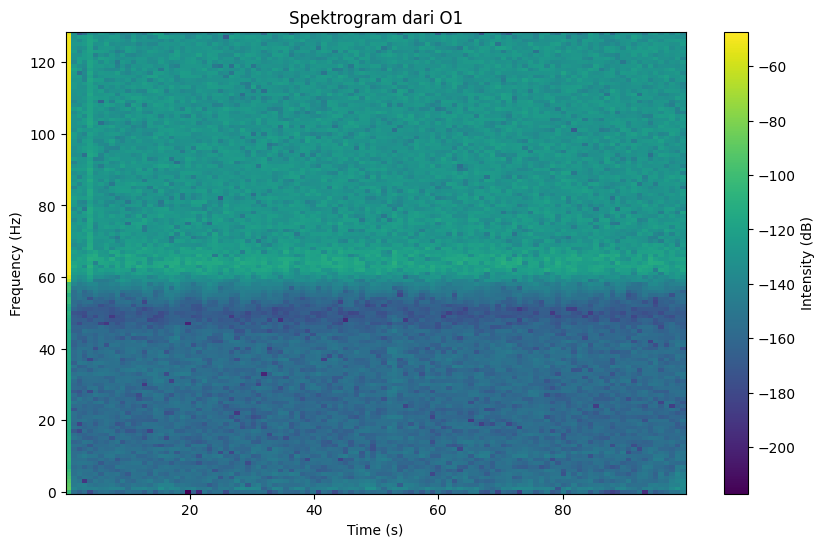

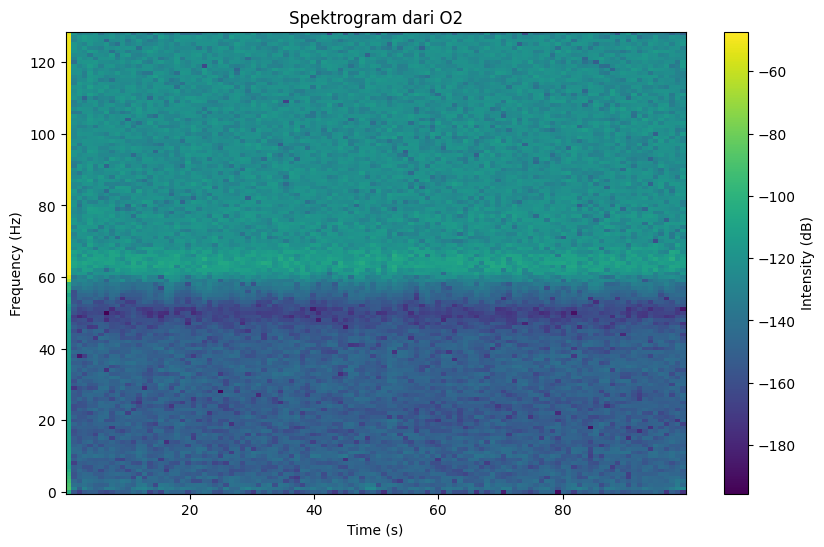

In [632]:
for i, channelName in enumerate(datasetSpec) :
    freqs, T, Sxx = spectrogram(dataHASILFILTER[i], fs=256)

    plt.figure(figsize=(10, 6))
    plt.pcolormesh(T, freqs, 10 * np.log10(Sxx), shading='auto')
    plt.colorbar(label='Intensity (dB)')
    plt.title(f'Spektrogram dari {channelName}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

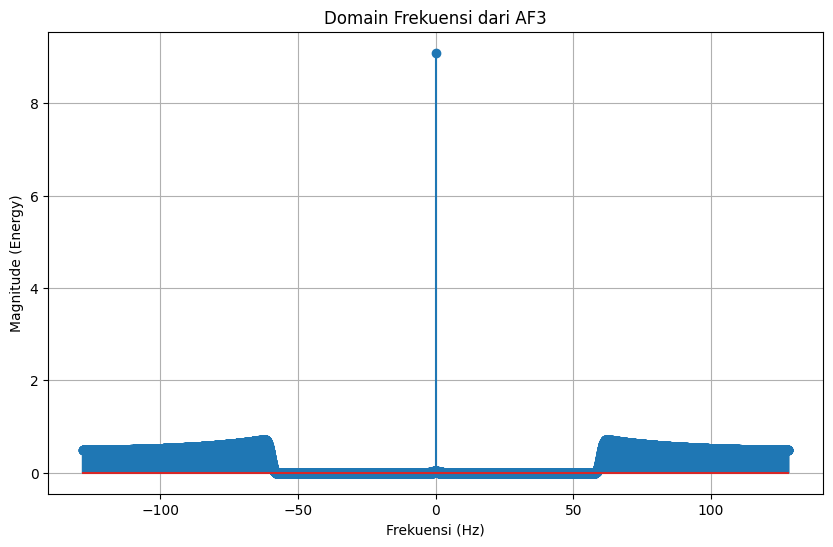

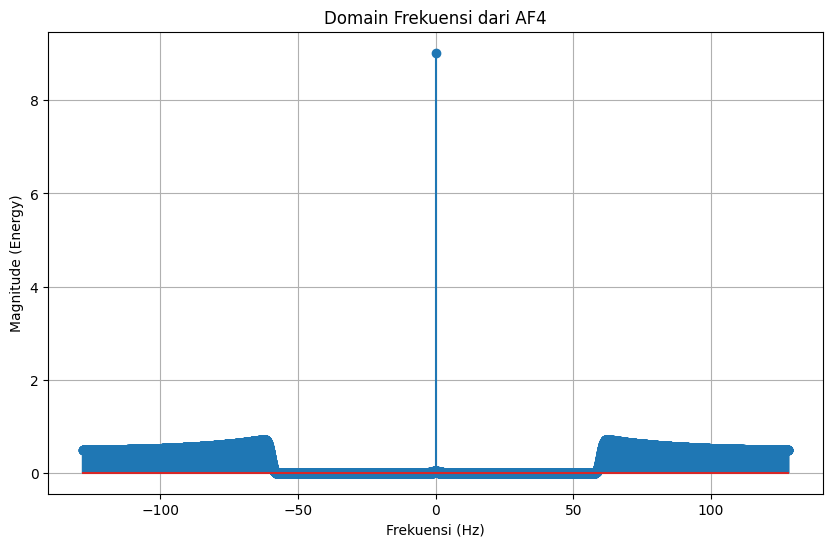

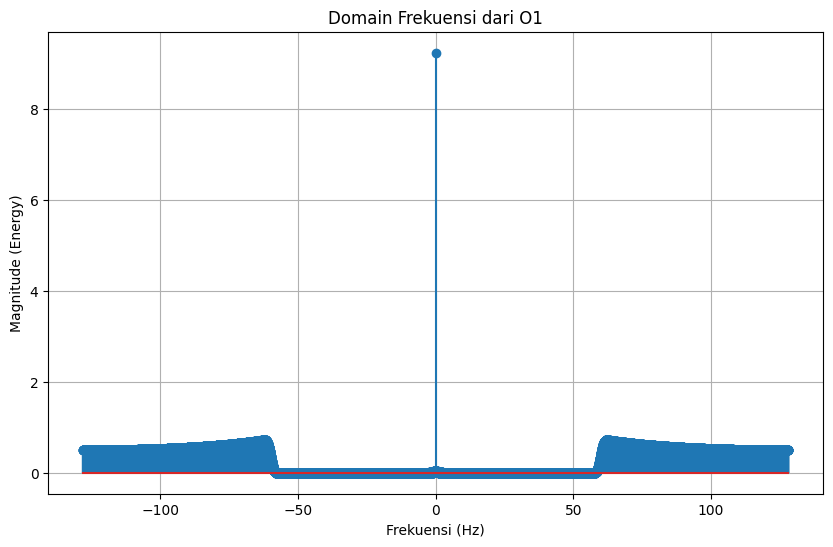

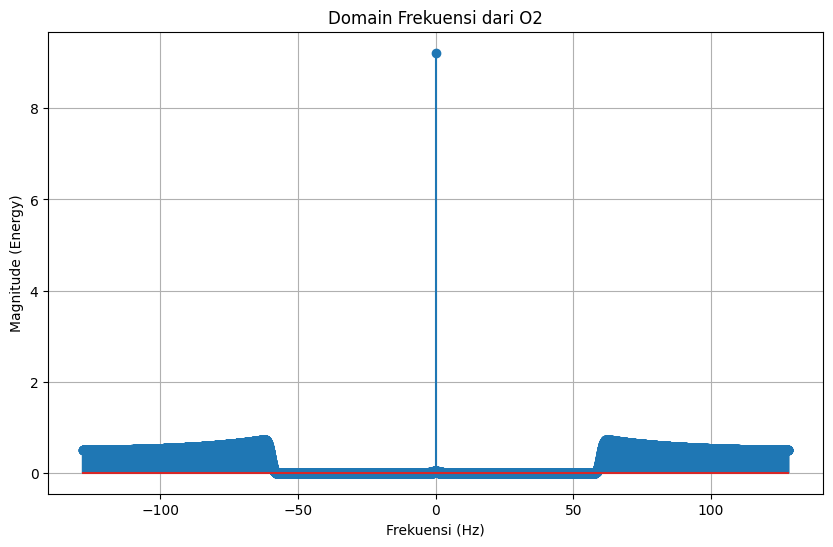

In [633]:
for i, channelName in enumerate(datasetSpec) :
    frequencies = np.fft.fftfreq(len(times), times[-1]/len(times))
    fft_values = np.fft.fft(dataHASILFILTER[i])

    plt.figure(figsize=(10, 6))
    plt.stem(frequencies, np.abs(fft_values))
    plt.title(f'Domain Frekuensi dari {channelName}')
    plt.xlabel('Frekuensi (Hz)')
    plt.ylabel('Magnitude (Energy)')
    plt.grid(True)
    plt.show()

In [634]:
for i, channelName in enumerate(datasetSpec) :
    snr = signaltonoise(dataHASILFILTER[i])
    print(channelName, " => ", snr)

AF3  =>  0.13939436640357153
AF4  =>  0.13908823341775792
O1  =>  0.14001623786507533
O2  =>  0.13948771630076373


TAHAP SEGMENTASI CHANNEL

In [635]:
def segmented_data(data, seg_length = 4, sampling = 256):
    ch = data.shape[0]
    cut = seg_length * sampling
    length = data.shape[1] - cut
    data = list(data)
    eeg_segments = []

    for i in range(ch):
        segs = []
        d = data[i]
        for j in range(0, length+1, cut):
            tmp = d[j:j+cut]
            segs.append(tmp)

        eeg_segments.append(segs)

    return np.asarray(eeg_segments)

In [636]:
dataSEGS = segmented_data(dataHASILFILTER)

dataSEGS.shape

(4, 25, 1024)

TAHAP EKSTRAKSI CHANNEL MENJADI TIGA

In [637]:
def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandpass')

    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered = filtfilt(b, a, data)

    return filtered

def bandpass_filter_segments(data, fs=128, order=3):

    ch_nums = data.shape[0]
    seg_nums = data.shape[1]
    seg_length = data.shape[2]

    ch_bands = np.empty((0, seg_nums, 3, seg_length))

    for i in range(ch_nums):
        segs_band = np.empty((0, 3, seg_length))

        for j in range(seg_nums):
            bands = None
            d = butter_bandpass_filter(data[i][j], 0.5, 4, fs=fs, order=order)
            t = butter_bandpass_filter(data[i][j], 4, 8, fs=fs, order=order)
            a = butter_bandpass_filter(data[i][j], 8, 13, fs=fs, order=order)
            bands = np.array([d, t, a])
            segs_band = np.append(segs_band, [bands], axis=0)

        ch_bands = np.append(ch_bands, [segs_band], axis=0)
        
    return ch_bands

(4, 25, 3, 1024)


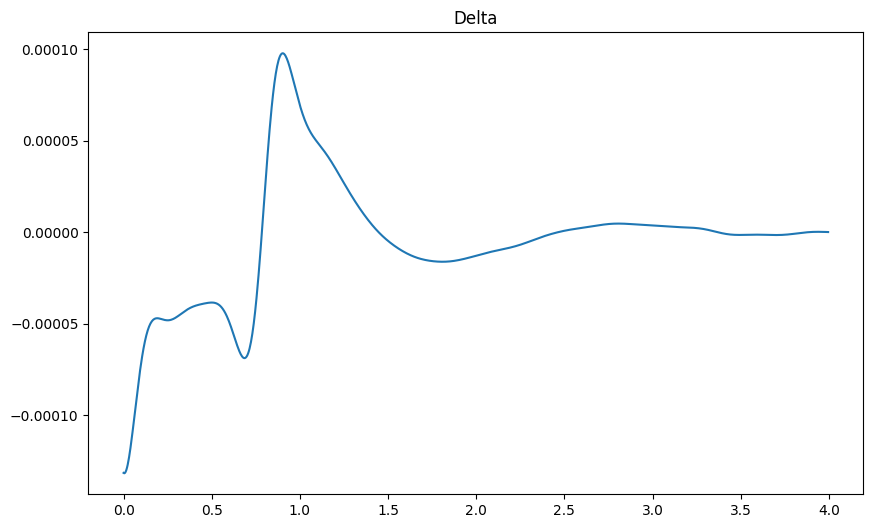

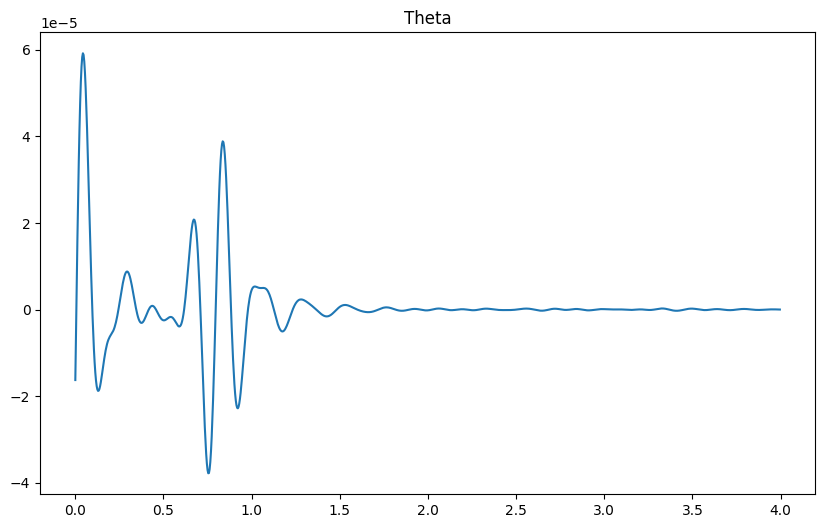

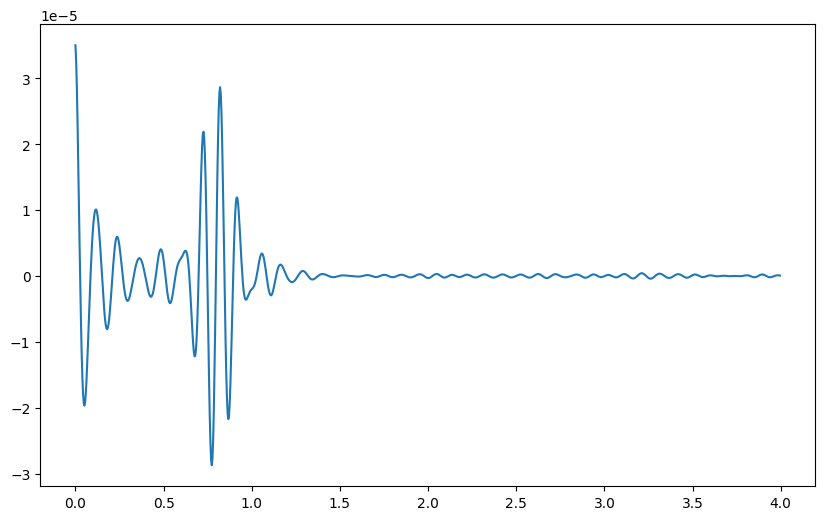

In [638]:
dataBANDS = bandpass_filter_segments(dataSEGS, fs=256, order=3)

print(dataBANDS.shape)

times = np.arange(1024)/256

plt.figure(figsize=(10,6))
plt.plot(times, dataBANDS[0][0][0])
plt.title("Delta")
plt.show()

plt.figure(figsize=(10,6))
plt.plot(times, dataBANDS[0][0][1])
plt.title("Tetha")
plt.show()

plt.figure(figsize=(10,6))
plt.plot(times, dataBANDS[0][0][2])
plt.title("Alpha")
plt.show()